In [1]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.trend_filter_R as tfilterR
import algorithms.trend_filter as tfilter

from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd
import json

0.000364944240613251
138.7893410354311
  Convergence criterion reached in 0 iterations.
inf
2.413854951491743e-06
0.007873050203253606
150.32543887519137
  Convergence criterion reached in 0 iterations.
inf
3.9534553542704943e-05


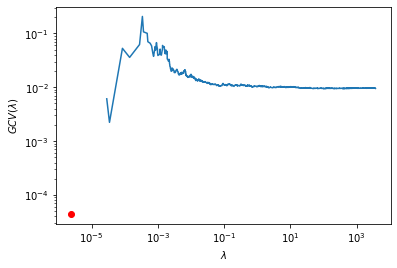

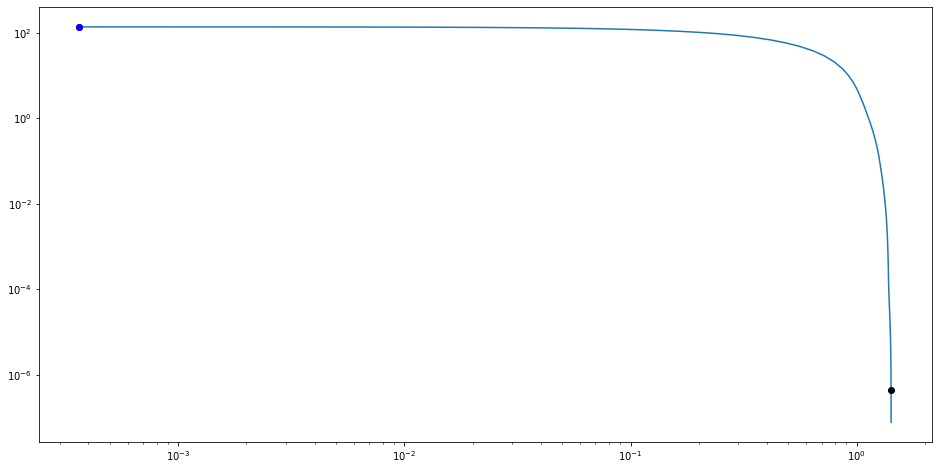

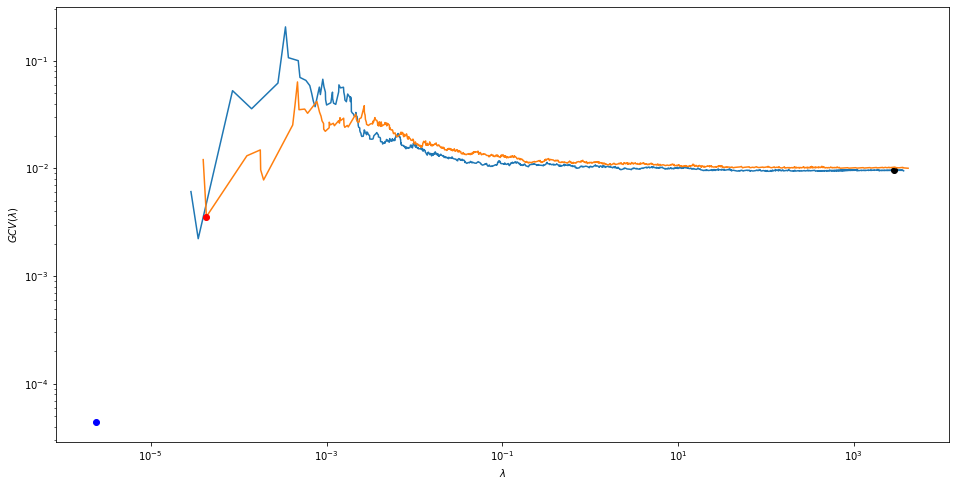

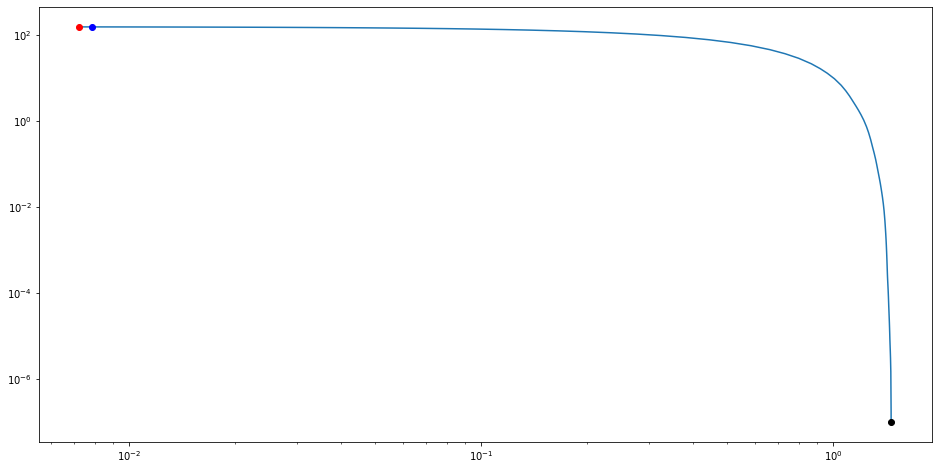

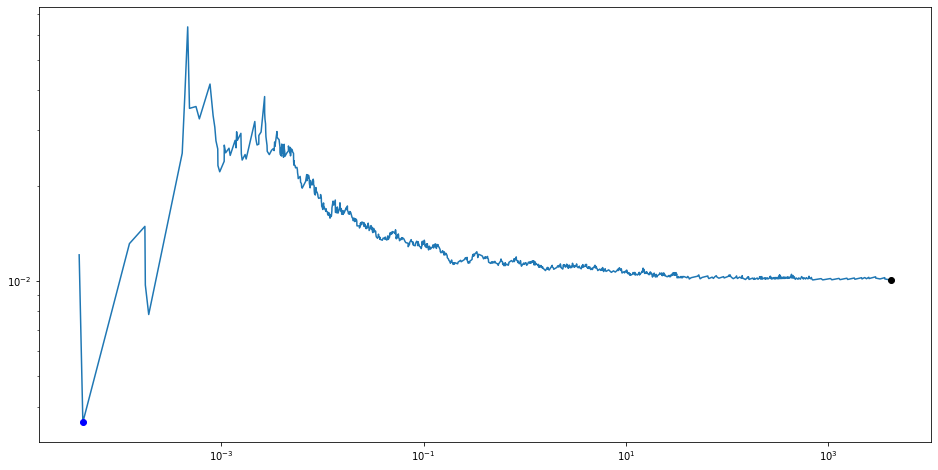

In [8]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/VanderPol_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)

noise_lvl = 0.1

write_data = True

## Select realization
sample = 0

##Range of lambdas
lambda_min = 1e-2
lambda_max = 1000000000
n_lambdas = 100

#Vreate dictionary to store values
lcurve_dict = {}
gcv_dict = {}


# LOAD OBSERVATION SAMPLES
Y_samples = []

for state in range(n_states):

    filepath = 'data_files/VanderPol_samples_noise_' + str(noise_lvl) +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')

    Y_samples.append(y)

n_samples = Y_samples[0].shape[0]

################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
# trim = int(np.floor(5 / 100 * t_samples))
# tt_samples = t_samples - 2 * trim


for state in range(n_states):

    y = Y_samples[state][sample,:]

    #GCV
    #tf_gcv = tfilterR.gcv(y, order = 3, lambda_min = lambda_min, lambda_max = lambda_max, n_lambdas = n_lambdas)
    tf_gcv = tfilterR.gcv(y, t, order = 3)
    lambdas, gcv_lambda = tf_gcv[1]
    min_gcv_indx = np.argmin(gcv_lambda)
    min_gcv = np.min(gcv_lambda)
    min_gcv_lambda = lambdas[min_gcv_indx] 

    y_tf_path = tf_gcv[2]

    error_path_gcv = np.zeros(y_tf_path.shape[1])
    for i in range(y_tf_path.shape[1]):
        error_path_gcv[i] = norm(y_tf_path[:,i] - X[state,:]) / norm(X[state,:])
    min_indx_error_gcv = np.argmin(error_path_gcv) 
    min_error_gcv_gcv = gcv_lambda[min_indx_error_gcv]
    min_error_gcv_lambda = lambdas[min_indx_error_gcv]

    #Solve for optimal gcv lambda
    tf_gcv_opt = tfilter.trend_filter(y, lambd = min_gcv_lambda, order = 3)
    res_gcv, reg_gcv = tf_gcv_opt[1]
    
    print(res_gcv)
    print(reg_gcv)
    
    lambda_min = np.min(lambdas)
    lambda_max = np.max(lambdas)
    
    #L-CURVE
    tf_flc = tfilter.full_lcurve(y, order = 3, lambda_min = lambda_min, lambda_max = lambda_max, n_lambdas = n_lambdas)
    tf_path = tf_flc[0]
    res, reg = tf_flc[1]
    error_path = np.zeros(tf_path.shape[1])
    for i in range(tf_path.shape[1]):
        error_path[i] = norm(tf_path[:,i] - X[state,:]) / norm(X[state,:])

    min_indx_lc = np.argmin(error_path)
    res_min = res[min_indx_lc]
    reg_min = reg[min_indx_lc]

    #Find corner point
    tf_lc = tfilter.lcurve_corner(y, order = 3, lambda_min = lambda_min, lambda_max = lambda_max)
    #tf_lc = tfilter.lcurve_corner(y, t, order = 3)
    y_tf = tf_lc[0]
    res_lc, reg_lc = tf_lc[3]
    lambda_lc = tf_lc[1]

    #Solve for optimal Lcurve lambda
    tf_lc_opt = tfilter.trend_filter(y, lambd = lambda_lc, order = 3)
    gcv_lc = tf_lc_opt[2][0]
    
    print(gcv_lc)
    print(lambda_lc)


    plt.figure(figsize = (16,8))
    plt.loglog(res, reg)
    plt.loglog(res_min, reg_min,'ko')
    plt.loglog(res_lc[-1], reg_lc[-1], 'ro')
    plt.loglog(res_gcv, reg_gcv, 'bo')

    lcurve_dict[f'state{state+1}:residual'] = res.tolist()
    lcurve_dict[f'state{state+1}:regularizer'] = reg.tolist()
    lcurve_dict[f'state{state+1}:res_corner'] = res_lc[-1]
    lcurve_dict[f'state{state+1}:reg_corner'] = reg_lc[-1]
    lcurve_dict[f'state{state+1}:res_min'] = res_min
    lcurve_dict[f'state{state+1}:reg_min'] = reg_min
    lcurve_dict[f'state{state+1}:res_gcv'] = res_gcv
    lcurve_dict[f'state{state+1}:reg_gcv'] = reg_gcv

    plt.figure(figsize = (16,8))
    plt.loglog(lambdas, gcv_lambda)
    plt.loglog(min_gcv_lambda, min_gcv, 'bo')
    plt.loglog(min_error_gcv_lambda, min_error_gcv_gcv, 'ko')
    plt.loglog(lambda_lc, gcv_lc, 'ro')

    gcv_dict[f'state{state+1}:lambdas'] = lambdas.tolist()
    gcv_dict[f'state{state+1}:gcv_func'] = gcv_lambda.tolist()
    gcv_dict[f'state{state+1}:lambda_lcurve'] = lambda_lc.tolist()
    gcv_dict[f'state{state+1}:gcv_lcurve'] = gcv_lc.tolist()
    gcv_dict[f'state{state+1}:min_error_lambda'] = min_error_gcv_lambda
    gcv_dict[f'state{state+1}:min_error_gcv'] = min_error_gcv_gcv
    gcv_dict[f'state{state+1}:min_lambda'] = min_gcv_lambda
    gcv_dict[f'state{state+1}:min_gcv'] = min_gcv
    gcv_dict[f'state{state+1}:res_gcv'] = res_gcv
    gcv_dict[f'state{state+1}:reg_gcv'] = reg_gcv

In [9]:
if write_data:
#     # STORE LCURVE IN JSON FORMAT
#     filename_lc = 'Lorenz63_trendfilter_lcurve_noise_' + str(noise_lvl).replace('.','d') + '.json'
#     filepath_lc = 'data_files/trendfilter/' + filename_lc
#     with open(filepath_lc, "w") as outfile:  
#         json.dump(lcurve_dict, outfile)  

    # STORE GCV IN JSON FORMAT
    filename_gcv = 'VanderPol_trendfilter_gcv_noise_' + str(noise_lvl).replace('.','d') + '.json'
    filepath_gcv = 'data_files/trendfilter/' + filename_gcv
    with open(filepath_gcv, "w") as outfile:  
        json.dump(gcv_dict, outfile) 